<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/keyuanren/RenTaGSim_NoNID_Exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Type-Aware Graph Embedding

### Loading New Dataset

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#---------- dataset with inconsistent GED length between 5 and 10
#get the train data from the drive
# id = '1s7ng3JypVvjtoUF8eUFPGroCTNtkxzIE'
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('updated_train.zip')
# #get the test data from the drive
# id = '11FK00L91jajUW15hzjsskNkN0DRsS_yN'
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('updated_test.zip')

#----------- dataset with consistent GED length 8
#get the train data from the drive
id = '1IPM6oe-oi4KIAhjm9LW9YEND9Q4nOJHF'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_GED8.zip')
#get the test data from the drive
id = '1zGd7pg46pLUbLmJ_VjEmyrO1PqeCzjvt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_GED8.zip')
!ls

sample_data  test_GED8.zip  train_GED8.zip


In [2]:
#if train and test exist do not run this part
#removing the dialog
%%capture
#unzip the file
# updated_train
# updated_test
!unzip train_GED8.zip
!unzip test_GED8.zip

### Data visualization

First graph: 13271.gexf


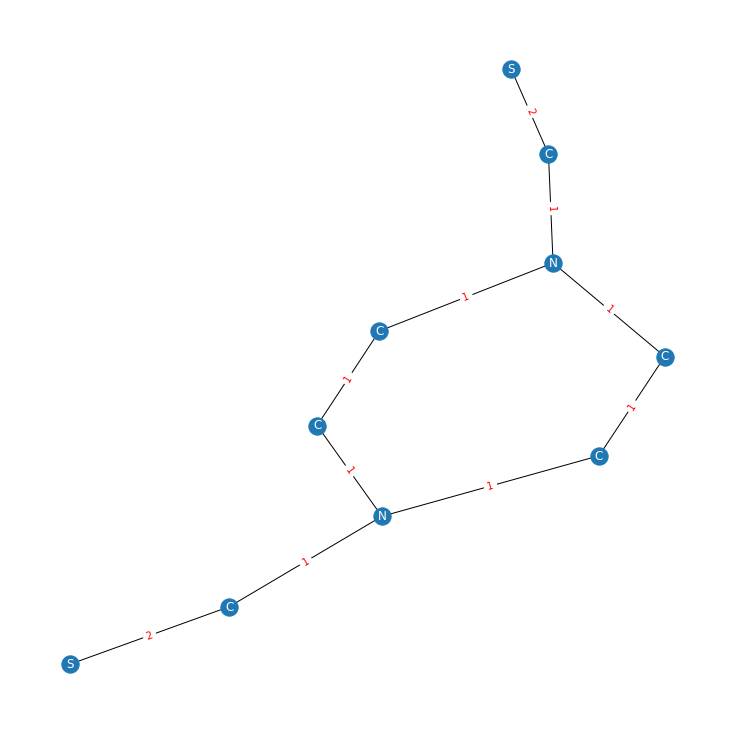

Second graph: 22421112_13271.gexf


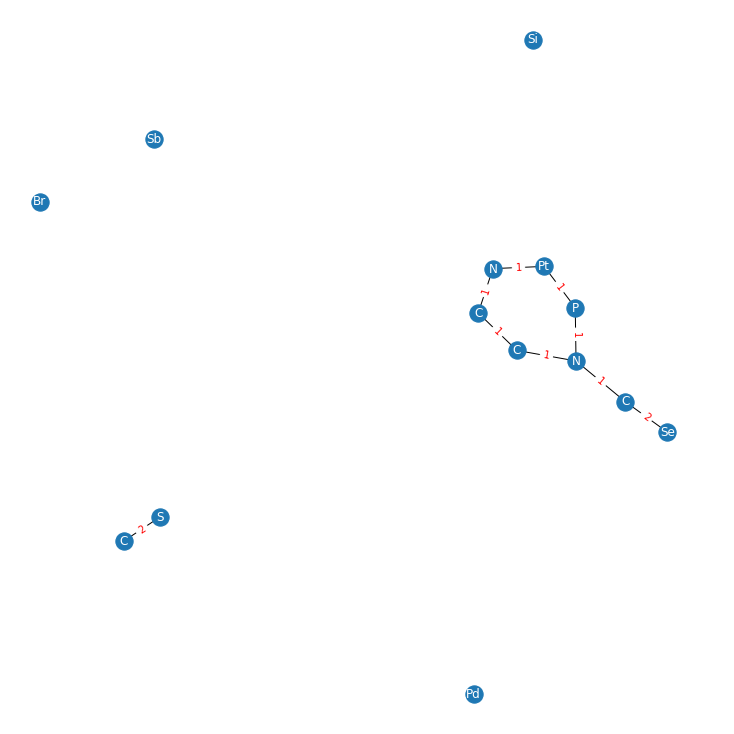

Their GED: 22421112


In [3]:
# pick a pair graph
import os
import random
import matplotlib.pyplot as plt
import networkx as nx

dirName = 'train/' #updated_train
filenames = os.listdir(dirName)

#pick random pair
pair_1 = random.choice(filenames)
while '_' in pair_1:
  pair_1 = random.choice(filenames)
for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      ged = pair_2.split('_', 1)[0]
#read pair 1
print("First graph: "+pair_1)
graph1 = nx.read_gexf('train/'+pair_1,version='1.2draft') #updated_train

node_info = nx.get_node_attributes(graph1, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph1.edges(data=True)])

#graph display
pos = nx.spring_layout(graph1, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph1, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph1, pos, edge_labels=edge_info, font_color="red")
plt.show()
#read pair 2
print("Second graph: "+pair_2)
graph2 = nx.read_gexf('train/'+pair_2,version='1.2draft') #updated_train

node_info = nx.get_node_attributes(graph2, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph2.edges(data=True)])

#graph display
pos = nx.spring_layout(graph2, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph2, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph2, pos, edge_labels=edge_info, font_color="red")
plt.show()
print("Their GED: "+ged)

###TaGSim Base-Model

In [ ]:
# import pprint
# label_multiset = transform_label_multiset(graph1, graph2, ged)
# pprint.pprint(label_multiset)

In [29]:
import torch
import numpy as np
class TensorNetworkModule(torch.nn.Module):
  def __init__(self, tensor_neurons, input_dim):
    super(TensorNetworkModule, self).__init__()
    self.input_dim = input_dim
    self.tensor_neurons = tensor_neurons
    self.setup_weights()
    self.init_parameters()

  def setup_weights(self):
    self.weight_matrix = torch.nn.Parameter(torch.Tensor(self.input_dim, self.input_dim, self.tensor_neurons))
    self.weight_matrix_block = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 2*self.input_dim))
    self.bias = torch.nn.Parameter(torch.Tensor(self.tensor_neurons, 1))

  def init_parameters(self):
    torch.nn.init.xavier_uniform_(self.weight_matrix)
    torch.nn.init.xavier_uniform_(self.weight_matrix_block)
    torch.nn.init.xavier_uniform_(self.bias)

  def forward(self, embedding_1, embedding_2):
    scoring = torch.mm(torch.t(embedding_1), self.weight_matrix.view(self.input_dim, -1))
    scoring = scoring.view(self.input_dim, self.tensor_neurons)
    scoring = torch.mm(torch.t(scoring), embedding_2)
    combined_representation = torch.cat((embedding_1, embedding_2))
    block_scoring = torch.mm(self.weight_matrix_block, combined_representation)
    scores = torch.nn.functional.relu(scoring + block_scoring + self.bias)
    return scores

def graph_aggregation_layer(input, adj):
    result = torch.mm(adj, input)
    return result

class TaGSim(torch.nn.Module):
  def __init__(self, number_of_node_labels, number_of_edge_labels, tensor_neurons, bottle_neck_neurons):
    super(TaGSim, self).__init__()
    self.number_of_node_labels = len(number_of_node_labels)
    self.number_of_edge_labels = len(number_of_edge_labels)
    self.node_type = number_of_node_labels
    self.edge_type = number_of_edge_labels
    self.tensor_neurons = tensor_neurons
    self.bottle_neck_neurons = bottle_neck_neurons
    self.setup_layers()
  
  def setup_layers(self):
    self.feature_count = self.tensor_neurons

    self.tensor_network_nc = TensorNetworkModule(self.tensor_neurons, 2*self.number_of_node_labels)
    # self.tensor_network_in = TensorNetworkModule(self.tensor_neurons, 2*self.number_of_node_labels)
    self.tensor_network_ie = TensorNetworkModule(self.tensor_neurons, 2*self.number_of_node_labels)
    self.tensor_network_ec = TensorNetworkModule(self.tensor_neurons, 2*self.number_of_edge_labels)

    self.fully_connected_first_nc = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
    self.fully_connected_second_nc = torch.nn.Linear(self.bottle_neck_neurons, 8)
    self.fully_connected_third_nc = torch.nn.Linear(8, 4)
    self.scoring_layer_nc = torch.nn.Linear(4, 1)

    # self.fully_connected_first_in = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
    # self.fully_connected_second_in = torch.nn.Linear(self.bottle_neck_neurons, 8)
    # self.fully_connected_third_in = torch.nn.Linear(8, 4)
    # self.scoring_layer_in = torch.nn.Linear(4, 1)

    self.fully_connected_first_ie = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
    self.fully_connected_second_ie = torch.nn.Linear(self.bottle_neck_neurons, 8)
    self.fully_connected_third_ie = torch.nn.Linear(8, 4)
    self.scoring_layer_ie = torch.nn.Linear(4, 1)

    self.fully_connected_first_ec = torch.nn.Linear(self.feature_count, self.bottle_neck_neurons)
    self.fully_connected_second_ec = torch.nn.Linear(self.bottle_neck_neurons, 8)
    self.fully_connected_third_ec = torch.nn.Linear(8, 4)
    self.scoring_layer_ec = torch.nn.Linear(4, 1)


  def gal_pass(self, edge_index, features):
    hidden1 = graph_aggregation_layer(features, edge_index)
    hidden2 = graph_aggregation_layer(hidden1, edge_index)

    return hidden1, hidden2
  
  def forward(self, label_multiset):
    adj_1, adj_2 = torch.FloatTensor(np.array(label_multiset["node_index_1"].todense())), torch.FloatTensor(np.array(label_multiset["node_index_2"].todense()))
    edge_adj_1, edge_adj_2 =  label_multiset["edge_adj_1"], label_multiset["edge_adj_2"]
    node_features_1, node_features_2 = label_multiset["node_features_1"], label_multiset["node_features_2"]
    edge_features_1, edge_features_2 = label_multiset["edge_features_1"], label_multiset["edge_features_2"]

    #gal
    graph1_hidden1, graph1_hidden2 = self.gal_pass(adj_1, node_features_1)#original graph node
    graph2_hidden1, graph2_hidden2 = self.gal_pass(adj_2, node_features_2)#generated graph node
    edge1_hidden1, edge1_hidden2 = self.gal_pass(edge_adj_1, edge_features_1)#original edge node
    edge2_hidden1, edge2_hidden2 = self.gal_pass(edge_adj_2, edge_features_2)#generated graph edge
    #node level embedding Concatenation
    graph1_01concat = torch.cat([node_features_1, graph1_hidden1], dim=1)
    graph2_01concat = torch.cat([node_features_2, graph2_hidden1], dim=1)
    graph1_12concat = torch.cat([graph1_hidden1, graph1_hidden2], dim=1)
    graph2_12concat = torch.cat([graph2_hidden1, graph2_hidden2], dim=1)
    #graph pooling: node Sum
    graph1_01pooled = torch.sum(graph1_01concat, dim=0).unsqueeze(1)
    graph2_01pooled = torch.sum(graph2_01concat, dim=0).unsqueeze(1)
    graph1_12pooled = torch.sum(graph1_12concat, dim=0).unsqueeze(1)
    graph2_12pooled = torch.sum(graph2_12concat, dim=0).unsqueeze(1)
    #edge level embedding Concatenation
    edge1_01concat = torch.cat([edge_features_1, edge1_hidden1], dim=1)
    edge2_01concat = torch.cat([edge_features_2, edge2_hidden1], dim=1)
    #graph pooling: edge Sum
    edge1_01pooled = torch.sum(edge1_01concat, dim=0).unsqueeze(1)
    edge2_01pooled = torch.sum(edge2_01concat, dim=0).unsqueeze(1)

    scores_nc = self.tensor_network_nc(graph1_01pooled, graph2_01pooled)
    scores_nc = torch.t(scores_nc)

    scores_nc = torch.nn.functional.relu(self.fully_connected_first_nc(scores_nc))
    scores_nc = torch.nn.functional.relu(self.fully_connected_second_nc(scores_nc))
    scores_nc = torch.nn.functional.relu(self.fully_connected_third_nc(scores_nc))
    score_nc = torch.sigmoid(self.scoring_layer_nc(scores_nc))

    # scores_in = self.tensor_network_in(graph1_01pooled, graph2_01pooled)
    # scores_in = torch.t(scores_in)

    # scores_in = torch.nn.functional.relu(self.fully_connected_first_in(scores_in))
    # scores_in = torch.nn.functional.relu(self.fully_connected_second_in(scores_in))
    # scores_in = torch.nn.functional.relu(self.fully_connected_third_in(scores_in))
    # score_in = torch.sigmoid(self.scoring_layer_in(scores_in))

    scores_ie = self.tensor_network_ie(graph1_12pooled, graph2_12pooled)
    scores_ie = torch.t(scores_ie)

    scores_ie = torch.nn.functional.relu(self.fully_connected_first_ie(scores_ie))
    scores_ie = torch.nn.functional.relu(self.fully_connected_second_ie(scores_ie))
    scores_ie = torch.nn.functional.relu(self.fully_connected_third_ie(scores_ie))
    score_ie = torch.sigmoid(self.scoring_layer_ie(scores_ie))

    scores_ec = self.tensor_network_ec(edge1_01pooled, edge2_01pooled)
    scores_ec = torch.t(scores_ec)

    scores_ec = torch.nn.functional.relu(self.fully_connected_first_ec(scores_ec))
    scores_ec = torch.nn.functional.relu(self.fully_connected_second_ec(scores_ec))
    scores_ec = torch.nn.functional.relu(self.fully_connected_third_ec(scores_ec))
    score_ec = torch.sigmoid(self.scoring_layer_ec(scores_ec))

    return torch.cat([score_nc, score_ie, score_ec], dim=1)

  def transform_label_multiset(self, graph_pair, type_specified=True):
    graph1 = graph_pair['graph_pair'][0]
    graph2 = graph_pair['graph_pair'][1]
    ged = graph_pair['ged']
    #node and edge info of pair graph
    node_info1 = nx.get_node_attributes(graph1, 'type')
    node_info2 = nx.get_node_attributes(graph2, 'type')
    edge_info1 = nx.get_edge_attributes(graph1, 'valence')
    edge_info2 = nx.get_edge_attributes(graph2, 'valence')
    nodes1 = list(graph1.nodes())
    nodes2 = list(graph2.nodes())
    edges1 = list(graph1.edges())
    edges2 = list(graph2.edges())

    label_multiset  = dict()
    node_features_1, node_features_2, edge_features_1, edge_features_2, edge_adj_1, edge_adj_2 = [], [], [], [], [], []

    for i in graph1.nodes():
      node_features_1.append([1.0 if node_info1[i] == node else 0.0 for node in self.node_type])
    for i in graph2.nodes():
      node_features_2.append([1.0 if node_info2[i] == node else 0.0 for node in self.node_type])
    node_features_1, node_features_2 = torch.FloatTensor(np.array(node_features_1)), torch.FloatTensor(np.array(node_features_2))

    for i in edges1:
      edge_features_1.append([1.0 if edge_info1[i] == edge else 0.0 for edge in self.edge_type])
      adj_row = []
      for d in edges1:
          if(i == d):
              adj_row.append(0.0)
              continue
          if((i[0] in d) | (i[1] in d)):
              adj_row.append(1.0)
          else:
              adj_row.append(0.0)
      edge_adj_1.append(adj_row)
    for i in edges2:
      edge_features_2.append([1.0 if edge_info2[i] == edge else 0.0 for edge in self.edge_type])
      adj_row = []
      for d in edges2:
          if(i == d):
              adj_row.append(0.0)
              continue
          if((i[0] in d) | (i[1] in d)):
              adj_row.append(1.0)
          else:
              adj_row.append(0.0)
      edge_adj_2.append(adj_row)
    edge_features_1, edge_features_2 = torch.FloatTensor(np.array(edge_features_1)), torch.FloatTensor(np.array(edge_features_2))
    edge_adj_1, edge_adj_2 = torch.FloatTensor(np.array(edge_adj_1)), torch.FloatTensor(np.array(edge_adj_2))

    label_multiset["node_index_1"], label_multiset["node_index_2"] = nx.adjacency_matrix(graph1), nx.adjacency_matrix(graph2)
    label_multiset["node_features_1"], label_multiset["node_features_2"] = node_features_1, node_features_2
    label_multiset["edge_features_1"], label_multiset["edge_features_2"] = edge_features_1, edge_features_2
    label_multiset["edge_adj_1"], label_multiset["edge_adj_2"] = edge_adj_1, edge_adj_2

    #ged normalisation
    if(type_specified):# for training
      norm_ged = [ged.count(key) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes())) for key in ['1','3','4']]
      norm_ged = np.array(norm_ged)
      label_multiset["target"] = torch.from_numpy(np.exp(-norm_ged)).view(1,-1).float()
      
      norm_gt_ged = (ged.count('1')+ged.count('3')+ged.count('4')) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
      label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()
    else:# for testing
      norm_gt_ged = (len(ged)) / (0.5 * (graph1.number_of_nodes() + graph2.number_of_nodes()))
      label_multiset["gt_ged"] = torch.from_numpy(np.exp(-norm_gt_ged).reshape(1, 1)).view(1, -1).float()

    return label_multiset

['C', 'N', 'O', 'Cu', 'F', 'S', 'Te', 'P', 'Ho', 'Tb', 'Co', 'Bi', 'Cl', 'Pt', 'Sn', 'Pb', 'Ni', 'As', 'B', 'Li', 'Ga', 'Ru', 'Pd', 'I', 'Br', 'Hg', 'Sb', 'Se', 'Si']
[3, 1, 2]

-------Model training---------.

Iteration 0 loss:  0.1278776079416275
Iteration 1 loss:  0.1246725469827652
Iteration 2 loss:  0.11839905381202698
Iteration 3 loss:  0.11317959002086095
Iteration 4 loss:  0.09886621683835983
Iteration 5 loss:  0.0988994687795639
Iteration 6 loss:  0.09378033131361008
Iteration 7 loss:  0.08349572760718209
Iteration 8 loss:  0.0815364271402359
Iteration 9 loss:  0.07640858739614487
Iteration 10 loss:  0.06874784827232361
Iteration 11 loss:  0.06735332948820931
Iteration 12 loss:  0.06370402127504349
Iteration 13 loss:  0.05806264281272888
Iteration 14 loss:  0.052809081971645355
Iteration 15 loss:  0.05173901574952262
Iteration 16 loss:  0.04763396084308624
Iteration 17 loss:  0.040975939482450485
Iteration 18 loss:  0.04535520076751709
Iteration 19 loss:  0.04062610013144357
I

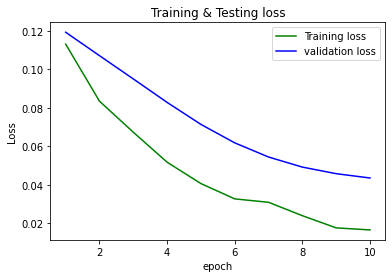

In [37]:
import matplotlib.pyplot as plt
epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

dirName = 'train/' #updated_train
filenames = os.listdir(dirName)
dirName_test = 'test/' #updated_test
filenames_test = os.listdir(dirName_test)
Node_Types = []
Edge_Types = []
#collection global node label and edge label info
for filename in filenames:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
for filename in filenames_test:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName_test+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
print(Node_Types)
print(Edge_Types)
globel_node_number = len(Node_Types)
globel_edge_number = len(Edge_Types)
print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
test_scores = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []

#training pair collection
for graph in range(0, int(len(filenames)/2)):
  pair_1 = random.choice(filenames)
  while '_' in pair_1:
    pair_1 = random.choice(filenames)
  for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      ged = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf('train/'+pair_1,version='1.2draft') #updated_train
  graph2 = nx.read_gexf('train/'+pair_2,version='1.2draft') #updated_train
  train_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#testing pair collection
for graph in range(0, int(len(filenames_test)/2)):
  pair_1_test = random.choice(filenames_test)
  while '_' in pair_1_test:
    pair_1_test = random.choice(filenames_test)
  for filename in filenames_test:
      if filename.endswith("_"+pair_1_test):
        pair_2_test = filename
        ged = pair_2_test.split('_', 1)[0]
  graph1 = nx.read_gexf('test/'+pair_1_test,version='1.2draft') #updated_test
  graph2 = nx.read_gexf('test/'+pair_2_test,version='1.2draft') #updated_test
  test_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#model training
for epoch in range(epochs):
  random.shuffle(train_pair)
  batches = []
  for graph in range(0, len(train_pair), batch_size):
    batches.append(train_pair[graph:graph+batch_size])

  for batch in batches:
    model.train()
    optimizer.zero_grad()
    losses = 0
    for graph_pair in batch:
      data = model.transform_label_multiset(graph_pair)
      prediction = model(data)
      losses += torch.nn.functional.mse_loss(data["target"], prediction)

    losses.backward(retain_graph=True)
    optimizer.step()
    loss = losses.item()
    print('Iteration', iteration, 'loss: ', loss/len(batch))
    iteration += 1

  visual_loss_train.append(loss/len(batch))
  # testing
  model.eval()
  for graph_pair in test_pair:
    data = model.transform_label_multiset(graph_pair, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())
  visual_loss_test.append(sum(test_scores) / len(test_scores))
  epo.append(epoch+1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training loss')
plt.plot(epo, visual_loss_test, 'b', label='validation loss')
plt.title('Training & Testing loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
print("\n-------Model testing---------.\n")
       
model.eval()
test_scores = []
test_pair = []
for graph in range(0, int(len(filenames_test)/2)):
  pair_1 = random.choice(filenames_test)
  while '_' in pair_1:
    pair_1 = random.choice(filenames_test)
  for filename in filenames_test:
      if filename.endswith("_"+pair_1):
        pair_2 = filename
        ged = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf('test/'+pair_1,version='1.2draft') #updated_test
  graph2 = nx.read_gexf('test/'+pair_2,version='1.2draft') #updated_test
  test_pair.append({"graph_pair":[graph1,graph2],"ged":ged})

for graph_pair in test_pair:
  data = model.transform_label_multiset(graph_pair, type_specified=False)
  prediction = model(data)
  prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
  current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
  test_scores.append(current_error.data.item())

model_error = sum(test_scores) / len(test_scores)
print("\nModel test error: " + str(model_error))


-------Model testing---------.


Model test error: 0.021856938237020326


['C', 'N', 'O', 'Cu', 'F', 'S', 'Te', 'P', 'Ho', 'Tb', 'Co', 'Bi', 'Cl', 'Pt', 'Sn', 'Pb', 'Ni', 'As', 'B', 'Li', 'Ga', 'Ru', 'Pd', 'I', 'Br', 'Hg', 'Sb', 'Se', 'Si']
[3, 1, 2]

-------Model training---------.

Iteration 0 loss:  0.13483397662639618
Iteration 1 loss:  0.12822648882865906
Iteration 2 loss:  0.1240784302353859
Iteration 3 loss:  0.11834544794900077
Iteration 4 loss:  0.11539041996002197
Iteration 5 loss:  0.11751881241798401
Iteration 6 loss:  0.10781264305114746
Iteration 7 loss:  0.10246654067720685
Iteration 8 loss:  0.10341887176036835
Iteration 9 loss:  0.09527913480997086
Iteration 10 loss:  0.09021400660276413
Iteration 11 loss:  0.08374862160001482
Iteration 12 loss:  0.07787855714559555
Iteration 13 loss:  0.0738864615559578
Iteration 14 loss:  0.0697350949048996
Iteration 15 loss:  0.06523476753916059
Iteration 16 loss:  0.057855553925037384
Iteration 17 loss:  0.05036749318242073
Iteration 18 loss:  0.05084860697388649
Iteration 19 loss:  0.051030095134462626


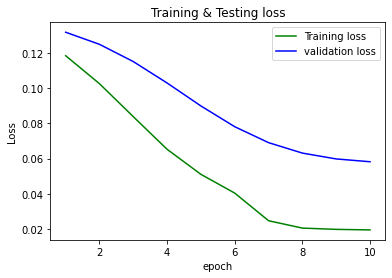

In [42]:
import matplotlib.pyplot as plt
epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

dirName = 'train/' #updated_train
filenames = os.listdir(dirName)
dirName_test = 'test/' #updated_test
filenames_test = os.listdir(dirName_test)
Node_Types = []
Edge_Types = []
#collection global node label and edge label info
for filename in filenames:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
for filename in filenames_test:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName_test+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
print(Node_Types)
print(Edge_Types)
globel_node_number = len(Node_Types)
globel_edge_number = len(Edge_Types)
print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
test_scores = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []

#training pair collection
for graph in range(0, int(len(filenames)/2)):
  pair_1 = random.choice(filenames)
  while '_' in pair_1:
    pair_1 = random.choice(filenames)
  for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      ged = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf('train/'+pair_1,version='1.2draft') #updated_train
  graph2 = nx.read_gexf('train/'+pair_2,version='1.2draft') #updated_train
  train_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#testing pair collection
for graph in range(0, int(len(filenames_test)/2)):
  pair_1_test = random.choice(filenames_test)
  while '_' in pair_1_test:
    pair_1_test = random.choice(filenames_test)
  for filename in filenames_test:
      if filename.endswith("_"+pair_1_test):
        pair_2_test = filename
        ged = pair_2_test.split('_', 1)[0]
  graph1 = nx.read_gexf('test/'+pair_1_test,version='1.2draft') #updated_test
  graph2 = nx.read_gexf('test/'+pair_2_test,version='1.2draft') #updated_test
  test_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#model training
for epoch in range(epochs):
  random.shuffle(train_pair)
  batches = []
  for graph in range(0, len(train_pair), batch_size):
    batches.append(train_pair[graph:graph+batch_size])

  for batch in batches:
    model.train()
    optimizer.zero_grad()
    losses = 0
    for graph_pair in batch:
      data = model.transform_label_multiset(graph_pair)
      prediction = model(data)
      losses += torch.nn.functional.mse_loss(data["target"], prediction)

    losses.backward(retain_graph=True)
    optimizer.step()
    loss = losses.item()
    print('Iteration', iteration, 'loss: ', loss/len(batch))
    iteration += 1

  visual_loss_train.append(loss/len(batch))
  # testing
  model.eval()
  for graph_pair in test_pair:
    data = model.transform_label_multiset(graph_pair, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())
  visual_loss_test.append(sum(test_scores) / len(test_scores))
  epo.append(epoch+1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training loss')
plt.plot(epo, visual_loss_test, 'b', label='validation loss')
plt.title('Training & Testing loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

['C', 'N', 'O', 'Cu', 'F', 'S', 'Te', 'P', 'Ho', 'Tb', 'Co', 'Bi', 'Cl', 'Pt', 'Sn', 'Pb', 'Ni', 'As', 'B', 'Li', 'Ga', 'Ru', 'Pd', 'I', 'Br', 'Hg', 'Sb', 'Se', 'Si']
[3, 1, 2]

-------Model training---------.

Iteration 0 loss:  0.2046932578086853
Iteration 1 loss:  0.16280999779701233
Iteration 2 loss:  0.1386464536190033
Iteration 3 loss:  0.11847896235329765
Iteration 4 loss:  0.102964386343956
Iteration 5 loss:  0.09258919954299927
Iteration 6 loss:  0.08021637052297592
Iteration 7 loss:  0.0774085521697998
Iteration 8 loss:  0.06973560899496078
Iteration 9 loss:  0.06213008984923363
Iteration 10 loss:  0.061877939850091934
Iteration 11 loss:  0.049299031496047974
Iteration 12 loss:  0.045487646013498306
Iteration 13 loss:  0.04072651267051697
Iteration 14 loss:  0.0301187876611948
Iteration 15 loss:  0.02747652360371181
Iteration 16 loss:  0.023276040330529213
Iteration 17 loss:  0.02358315698802471
Iteration 18 loss:  0.02449401281774044
Iteration 19 loss:  0.01952011457511357
I

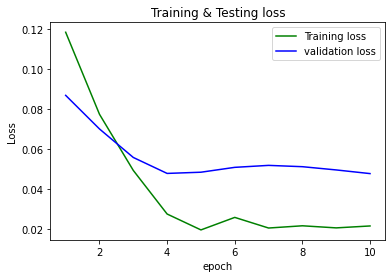

In [43]:
import matplotlib.pyplot as plt
epochs = 10
tensor_neurons = 16
bottle_neck_neurons = 16
batch_size = 128
dropout = 0.0
lr = 0.001
weight_decay = 0.0

dirName = 'train/' #updated_train
filenames = os.listdir(dirName)
dirName_test = 'test/' #updated_test
filenames_test = os.listdir(dirName_test)
Node_Types = []
Edge_Types = []
#collection global node label and edge label info
for filename in filenames:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
for filename in filenames_test:
    if filename.endswith(".gexf"):
        #print(filename)
        temp =  nx.read_gexf(path=dirName_test+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)
print(Node_Types)
print(Edge_Types)
globel_node_number = len(Node_Types)
globel_edge_number = len(Edge_Types)
print("\n-------Model training---------.\n")

model = TaGSim(Node_Types, Edge_Types, tensor_neurons, bottle_neck_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0

visual_loss_train = []
test_scores = []
visual_loss_test = []
train_pair = []
test_pair = []
epo = []

#training pair collection
for graph in range(0, int(len(filenames)/2)):
  pair_1 = random.choice(filenames)
  while '_' in pair_1:
    pair_1 = random.choice(filenames)
  for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      ged = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf('train/'+pair_1,version='1.2draft') #updated_train
  graph2 = nx.read_gexf('train/'+pair_2,version='1.2draft') #updated_train
  train_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#testing pair collection
for graph in range(0, int(len(filenames_test)/2)):
  pair_1_test = random.choice(filenames_test)
  while '_' in pair_1_test:
    pair_1_test = random.choice(filenames_test)
  for filename in filenames_test:
      if filename.endswith("_"+pair_1_test):
        pair_2_test = filename
        ged = pair_2_test.split('_', 1)[0]
  graph1 = nx.read_gexf('test/'+pair_1_test,version='1.2draft') #updated_test
  graph2 = nx.read_gexf('test/'+pair_2_test,version='1.2draft') #updated_test
  test_pair.append({"graph_pair":[graph1,graph2],"ged":ged})
#model training
for epoch in range(epochs):
  random.shuffle(train_pair)
  batches = []
  for graph in range(0, len(train_pair), batch_size):
    batches.append(train_pair[graph:graph+batch_size])

  for batch in batches:
    model.train()
    optimizer.zero_grad()
    losses = 0
    for graph_pair in batch:
      data = model.transform_label_multiset(graph_pair)
      prediction = model(data)
      losses += torch.nn.functional.mse_loss(data["target"], prediction)

    losses.backward(retain_graph=True)
    optimizer.step()
    loss = losses.item()
    print('Iteration', iteration, 'loss: ', loss/len(batch))
    iteration += 1

  visual_loss_train.append(loss/len(batch))
  # testing
  model.eval()
  for graph_pair in test_pair:
    data = model.transform_label_multiset(graph_pair, type_specified=False)
    prediction = model(data)
    prediction = torch.exp(torch.sum(torch.log(prediction))).view(1, -1)
    current_error = torch.nn.functional.mse_loss(prediction, data["gt_ged"])
    test_scores.append(current_error.data.item())
  visual_loss_test.append(sum(test_scores) / len(test_scores))
  epo.append(epoch+1)

#visualization of traning and testing loss
plt.plot(epo, visual_loss_train, 'g', label='Training loss')
plt.plot(epo, visual_loss_test, 'b', label='validation loss')
plt.title('Training & Testing loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()